In [1]:
import numpy as np
import pandas as pd
import pystan
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from src.stan_data_format import format_stan_data_logistic
from src.utils import pickle_model, load_model, make_latex_table, save_latex_table
from src.clean import clean_exp_2, clean_exp_1, clean_exp3
from multiprocessing import cpu_count

import os
print(pystan.__version__)

%matplotlib inline


2.19.1.1


In [2]:
import os
os.environ['STAN_NUM_THREADS'] = str(cpu_count())
os.environ['NUMEXPR_NUM_THREADS'] = str(cpu_count())


In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

<H1>Preprocessing</H1> 


In [4]:
# File locations
EXPERIMENT_1 = './dat/raw/Experiment1.csv'
EXPERIMENT_2 = './dat/raw/Experiment2.csv'
EXPERIMENT_3 = './dat/raw/Experiment3.csv'

# Output locations
FIGURE_OUTPUT = './out/figures/'
CHAIN_OUTPUT = './out/chains/'
MODEL_OUTPUT = './out/models/'


TABLE_OUTPUT = './out/tables/'
CLEAN_DATA_EXP1 = './dat/cleaned/clean_exp1.csv'
CLEAN_DATA_EXP2 = './dat/cleaned/clean_exp2.csv'

SIMULATION_DATA = './dat/cleaned/simulation.csv'

# Utility function for inv_logit


def ilogit(x):
    return 1/(1+np.exp(-x))

for location in [FIGURE_OUTPUT, CHAIN_OUTPUT, MODEL_OUTPUT, TABLE_OUTPUT]:
    if not os.path.exists(location):
        os.makedirs(location)
        print("created folder : ", location)
    else:
        print(location, "folder already exists.")

./out/figures/ folder already exists.
./out/chains/ folder already exists.
./out/models/ folder already exists.
./out/tables/ folder already exists.


In [5]:
# Clean and save data.
clean_exp1_df = clean_exp_1(pd.read_csv(EXPERIMENT_1))
clean_exp1_df.to_csv(CLEAN_DATA_EXP1)

In [6]:
# Clean and save data.
clean_exp2_df = clean_exp_2(pd.read_csv(EXPERIMENT_2, skiprows=[1, 2]))
clean_exp2_df.to_csv(CLEAN_DATA_EXP2)

<h2>Extract demographic information for experiments 1, 2</h3>

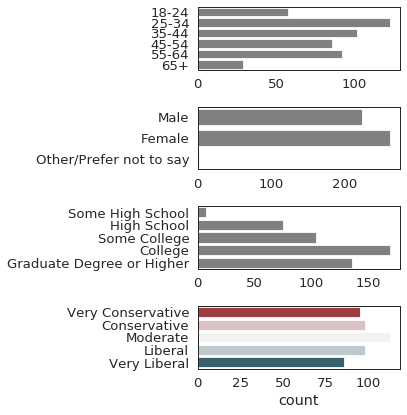

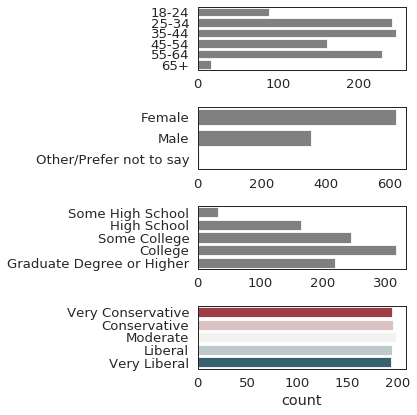

In [7]:
from src.demographics import demographics_exp_1, demographics_exp_2
# Plot demographic figures for SI
plt.figure(figsize=(6, 6))
dem1 = demographics_exp_1(pd.read_csv(EXPERIMENT_1))
plt.savefig(FIGURE_OUTPUT+'Exp1_demographics.pdf', fmt='pdf')
plt.figure(figsize=(6, 6))
dem2 = demographics_exp_2(pd.read_csv(CLEAN_DATA_EXP2))
plt.savefig(FIGURE_OUTPUT+'Exp2_demographics.pdf', fmt='pdf')

<h1>Experiment 1 Analysis</h1>

<h2>Convidence vs. Accuracy</h3> 

In [8]:
model_confidence_accuracy_logit = pystan.StanModel(
    file='./src/confidence_accuracy_logit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3427a9a7c8850d25368b67c8c12231fc NOW.


<h3>Prior Predictive Check</h3>

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


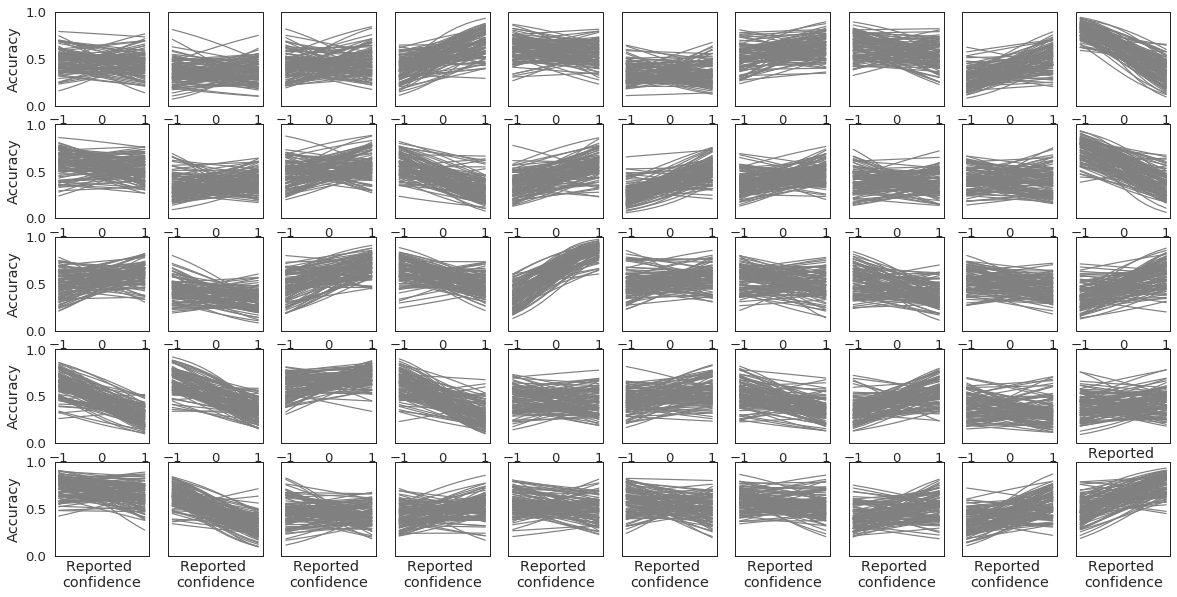

In [9]:
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
def plot_figure1b_prior(stan_data_logistic):
    x = np.linspace(np.min(stan_data_logistic['x']),np.max(stan_data_logistic['x']),10)
    plt.figure(figsize=(20, 10))
    for kdx in range(10):
        for idx in range(5):
            plot_no = idx+1 + 5 * kdx
            plt.subplot(5,10,plot_no)
            alpha_p = np.random.normal(0,.4, 1)
            beta_p = np.random.normal(0,.4, 1)
            alpha = np.random.normal(alpha_p, .4, 100)
            beta = np.random.normal(beta_p, .4, 100)
            y = np.array([alpha + beta * item for item in  x])
            y = ilogit(y)
            plt.plot(x,y, color='grey')
            #plt.ylim(.2,.8)
            #plt.xlim(50,100)
            
            if plot_no%10 == 1:
                plt.ylabel('Accuracy')
            else:
                plt.yticks([])
            if plot_no >= 40:
                plt.xlabel('Reported \nconfidence')
                plt.xticks([])
            plt.ylim(0,1)

plot_figure1b_prior(stan_data_logistic)

<h3>Sample and evaluate MCMC</h3>

Sampling confidence-accuracy model...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/home/joseph/github/Collective-wisdom-in-polarized-groups/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)
INFO:numba.core.transforms:finding looplift candidates


...sampling complete


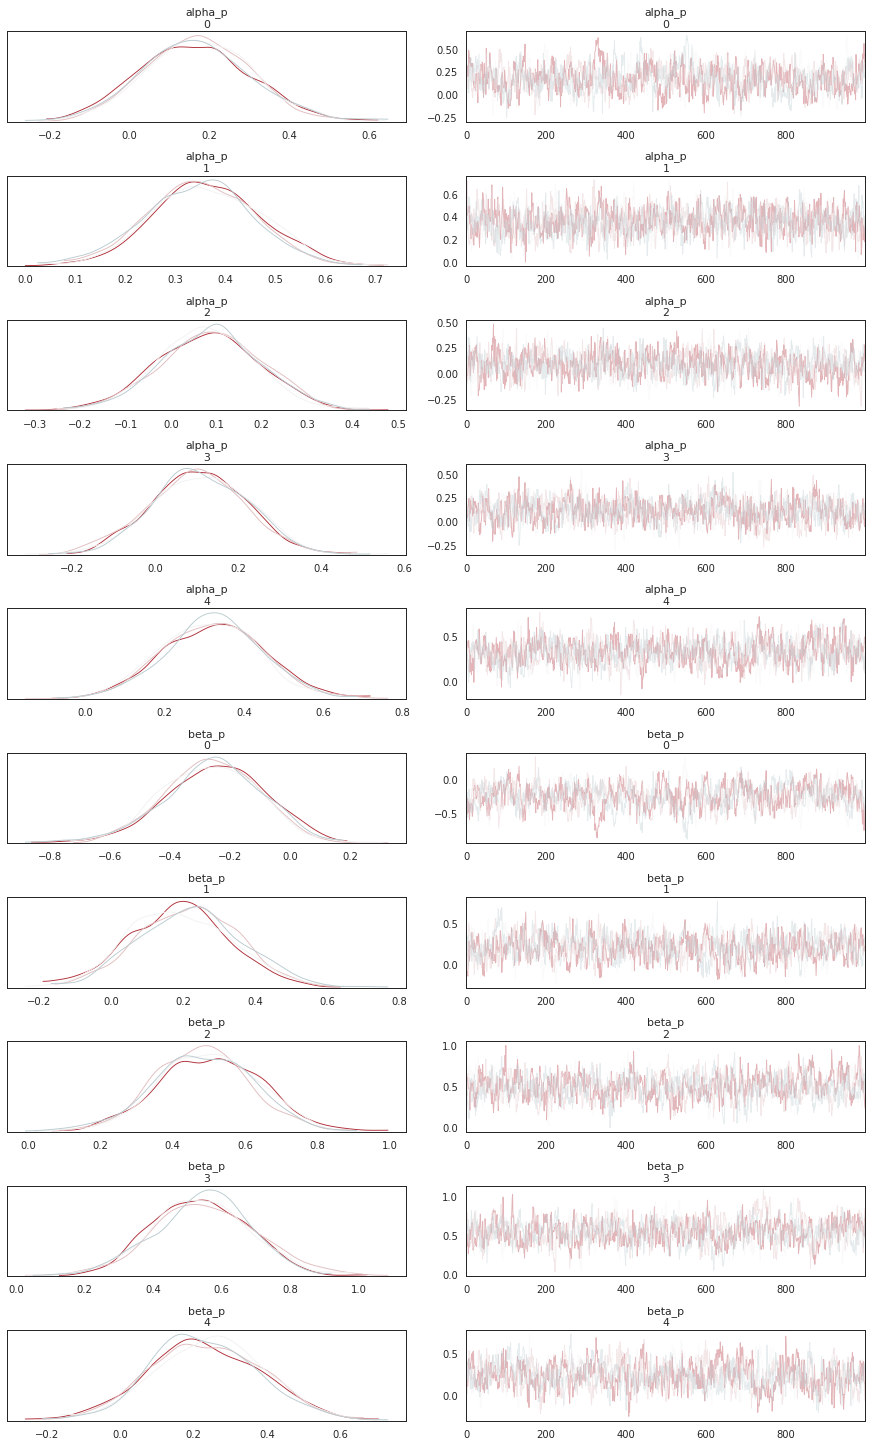

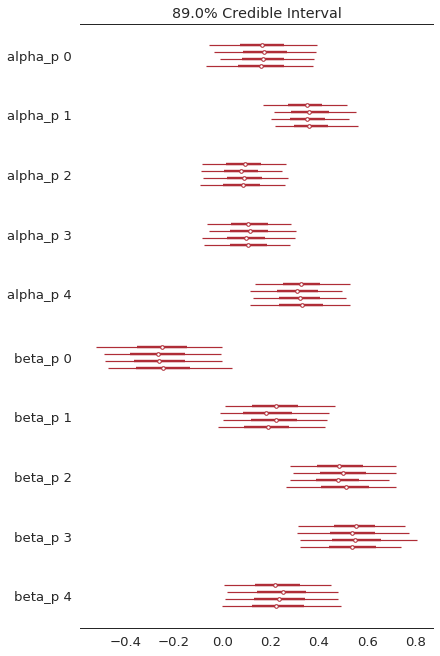

In [10]:
print('Sampling confidence-accuracy model...')
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
# MCMC  Time
samples_logistic = model_confidence_accuracy_logit.sampling(
    data=stan_data_logistic)

# Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
# Save model and output for easy loading later.
pickle_model(model_confidence_accuracy_logit,
             samples_logistic,
             MODEL_OUTPUT,
             CHAIN_OUTPUT,
             'confidence_accuracy_logit')
# Plot chains
#samples_logistic.plot(pars=['alpha_p', 'beta_p'])
az.plot_trace(samples_logistic,
              var_names=['alpha_p', 'beta_p'])
az.plot_forest(samples_logistic, var_names=[
               'alpha_p', 'beta_p'], credible_interval=.89)
print('...sampling complete')

In [11]:
print('Saving results...',)

model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT,
                                                               'confidence_accuracy_logit')

Saving results...


<h3>Figure and Table output</h3>

In [12]:
print("Generating and saving tables and figures for confidence-accuracy model...")
# Save key output as a LaTeX file.
variables = ['alpha_p', 'beta_p']
extracted_samples_logistic['beta_p']
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_accuracy_logit.tex', latex_string)

Generating and saving tables and figures for confidence-accuracy model...
\begin{tabular}{lrrrrr}
\toprule
variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_p &  0.169038 &  0.134965 & -0.042270 &  0.165699 &  0.387468 \\
 alpha\_p &  0.357032 &  0.107871 &  0.187138 &  0.355412 &  0.530135 \\
 alpha\_p &  0.084774 &  0.109912 & -0.089605 &  0.085785 &  0.261260 \\
 alpha\_p &  0.106514 &  0.114830 & -0.080043 &  0.105234 &  0.289634 \\
 alpha\_p &  0.320653 &  0.125005 &  0.120176 &  0.321353 &  0.518451 \\
  beta\_p & -0.258884 &  0.161517 & -0.520572 & -0.254892 & -0.008312 \\
  beta\_p &  0.204095 &  0.141140 & -0.017556 &  0.203693 &  0.433655 \\
  beta\_p &  0.491825 &  0.137655 &  0.272165 &  0.493731 &  0.710963 \\
  beta\_p &  0.544075 &  0.144430 &  0.318010 &  0.543688 &  0.773659 \\
  beta\_p &  0.234989 &  0.148176 &  0.002874 &  0.231430 &  0.474598 \\
\bottomrule
\end{tabular}



In [13]:
from src.exp_1_figures import plot_figure1a
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plt.savefig(FIGURE_OUTPUT+'joint_hpdi.pdf', fmt='pdf')

<Figure size 432x288 with 0 Axes>

/home/joseph/github/Collective-wisdom-in-polarized-groups/src/exp_1_figures.py:49: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(xi, yi, zi,levels = levels,
/home/joseph/github/Collective-wisdom-in-polarized-groups/src/exp_1_figures.py:49: UserWarning: The following kwargs were not used by contour: 'shade'
  CS = plt.contourf(xi, yi, zi,levels = levels,


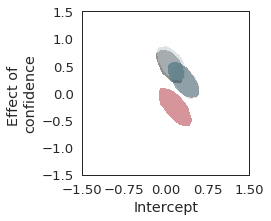

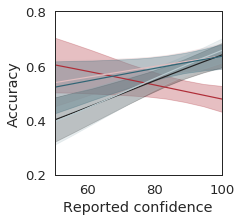

In [14]:
from src.exp_1_figures import joint_hpdi

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
joint_hpdi(extracted_samples_logistic)


from src.exp_1_figures import plot_figure1b

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
plot_figure1b(extracted_samples_logistic, stan_data_logistic)



<h3>Accuracy by Political Leaning</h3>

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9434beb2b0>],
      dtype=object)

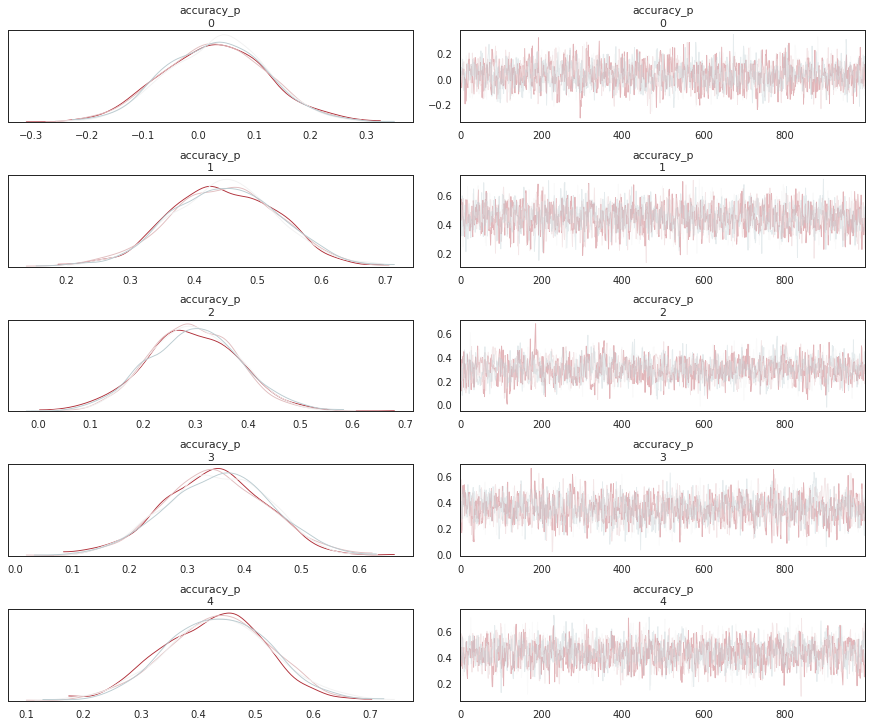

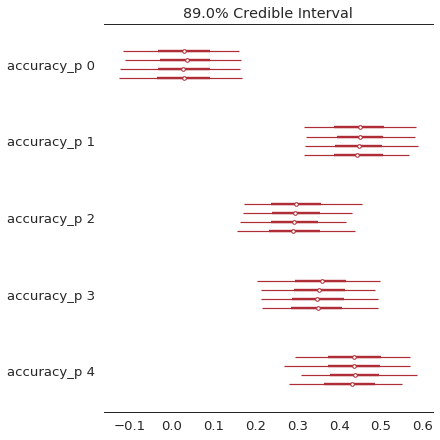

In [15]:
az.plot_trace(samples_logistic, var_names=['accuracy_p'])
az.plot_forest(samples_logistic, var_names=['accuracy_p'],
               credible_interval=.89)

In [16]:
extracted_samples_logistic = samples_logistic.extract(['accuracy_p'])
variables = ['accuracy_p']
extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'accuracy.tex', latex_string)
print("Complete")

\begin{tabular}{lrrrrr}
\toprule
   variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 accuracy\_p &  0.507518 &  0.022577 &  0.471884 &  0.507806 &  0.543588 \\
 accuracy\_p &  0.609894 &  0.020172 &  0.578238 &  0.610088 &  0.641138 \\
 accuracy\_p &  0.573231 &  0.020950 &  0.539951 &  0.572780 &  0.606168 \\
 accuracy\_p &  0.586671 &  0.021866 &  0.551473 &  0.586941 &  0.620670 \\
 accuracy\_p &  0.606442 &  0.021370 &  0.571129 &  0.606930 &  0.639896 \\
\bottomrule
\end{tabular}

Complete


<h2>Agent model of confidence</h2>

<h3>Prior Predictitive Checks</h3>

Sampling agent model of confidence...


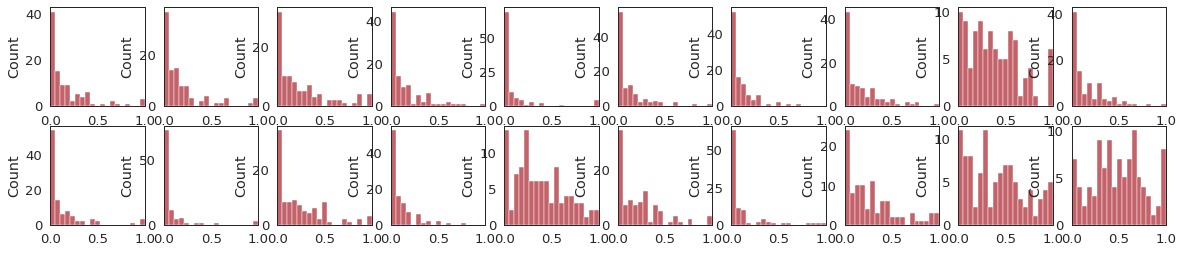

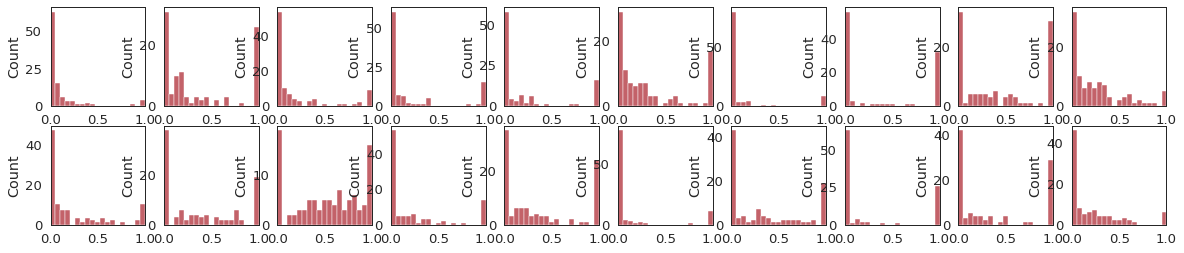

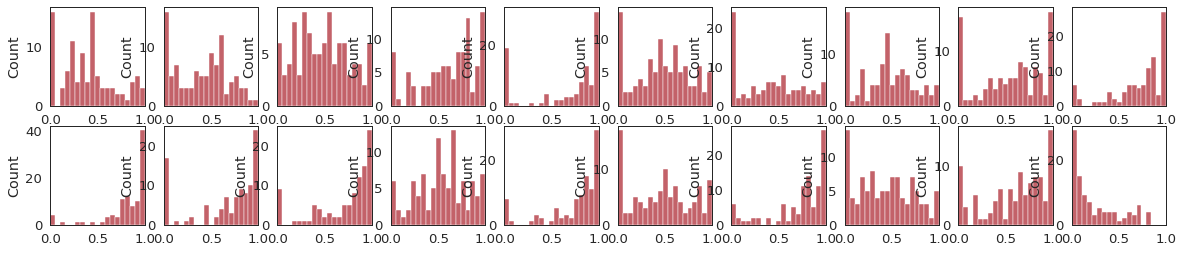

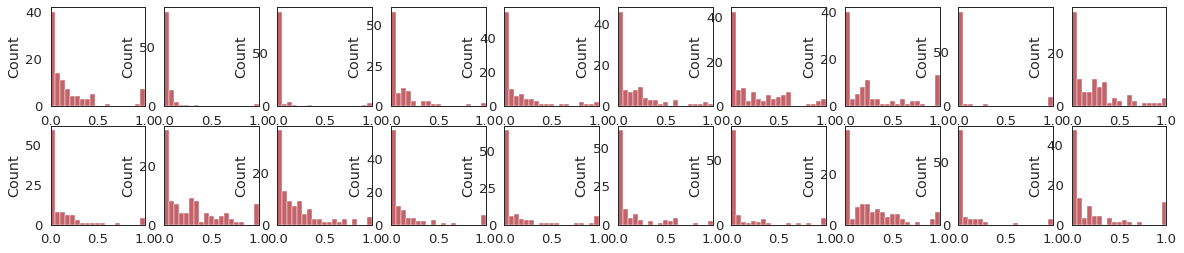

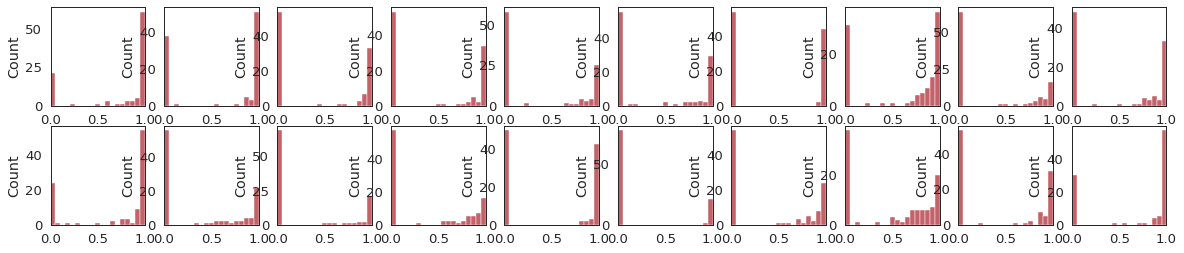

In [17]:
print("Sampling agent model of confidence...")
#Simulate different political groups
correct = 1 #Change to zero to simulate when incorrect

for p in range(5):
    plt.figure(figsize=(20,4))
    mu_a_pol  = np.random.normal(0,1)
    alpha_a_pol =  np.random.normal(-1,1)
    gamma_a_pol =  np.random.normal(0,1)

    mu_b_pol  =  np.random.normal(0,.5)
    alpha_b_pol =  np.random.normal(0,.5)
    gamma_b_pol =  np.random.normal(0,.5)
    #And Individuals
    for k in range(20):



        mu_a = np.random.normal(mu_a_pol,.5)
        alpha_a = np.random.normal(alpha_a_pol,.5)
        gamma_a = np.random.normal(gamma_a_pol,.5)

        mu_b  = np.random.normal(mu_b_pol,.5)
        alpha_b = np.random.normal(alpha_b_pol,.5)
        gamma_b = np.random.normal(gamma_b_pol,.5)


        mu = np.zeros(100)
        alpha = np.zeros(100)
        gamma = np.zeros(100)
        y_sim = np.zeros(100)


        plt.subplot(2,10,k+1)
        for i in range(100):
            theta = abs(np.random.normal(0,5));
            mu[i] = ilogit(mu_a + mu_b*correct);
            alpha[i] = ilogit(alpha_a + alpha_b*correct);
            gamma[i] = ilogit(gamma_a + gamma_b*correct);

            if np.random.binomial(1, alpha[i])==1:
                if np.random.binomial(1, gamma[i]) == 1:
                    y_sim[i] = 1
                else:
                    y_sim[i] = 0
            else: 
                y_sim[i] = np.random.beta(mu[i]*theta, (1-mu[i])*theta)

        sns.histplot(y_sim,bins=np.linspace(0,1,20))
        plt.xlim(0,1)
    

<h3>Model compiliation and Sampling</h3>


In [18]:
belief_model = pystan.StanModel(file='./src/belief_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e5b3cb09920a7f1c37ee7574bf7946a NOW.


In [19]:
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
from src.stan_data_format import format_stan_data_belief
stan_data = format_stan_data_belief(exp_1_data)
belief_samples = belief_model.sampling(data = stan_data)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [20]:
pickle_model(belief_model, 
             belief_samples, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'belief')

/home/joseph/github/Collective-wisdom-in-polarized-groups/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


<h3>Evaluate MCMC</h3>

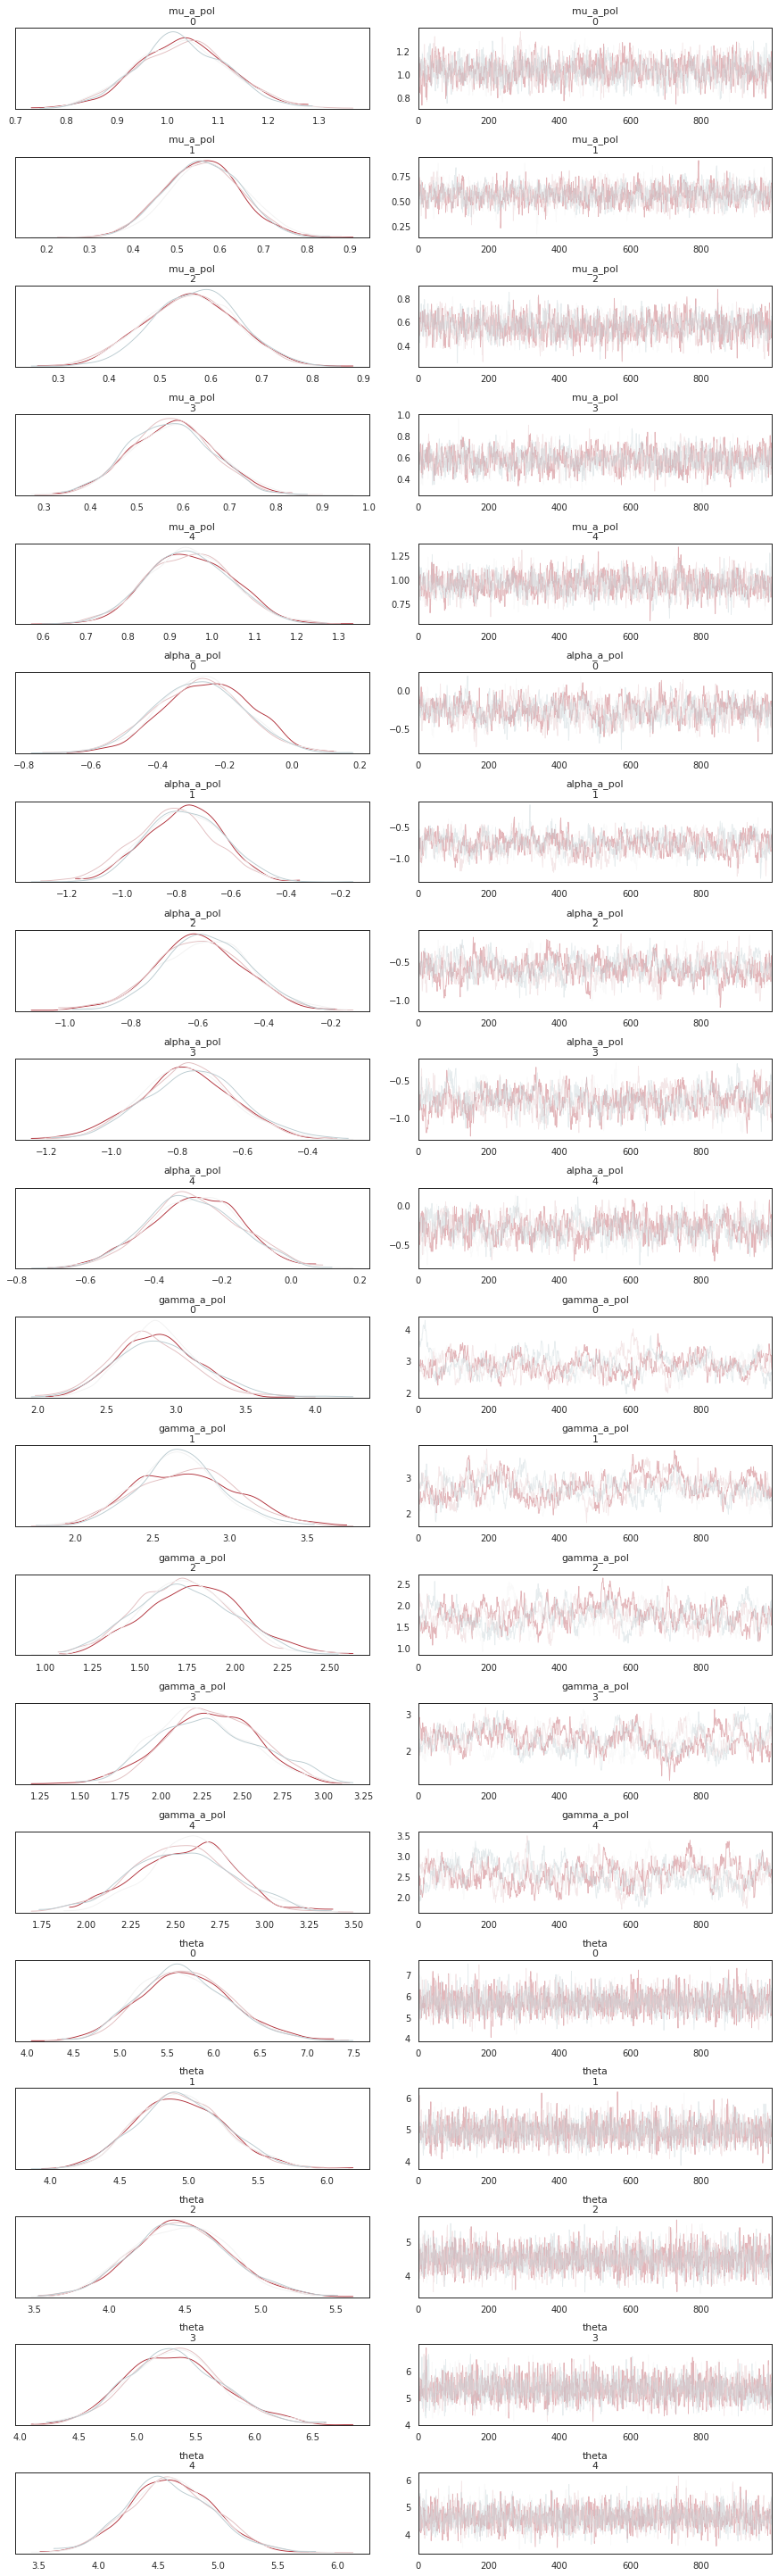

In [21]:
az.plot_trace(belief_samples, 
              var_names=['mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol',
                        'theta']);

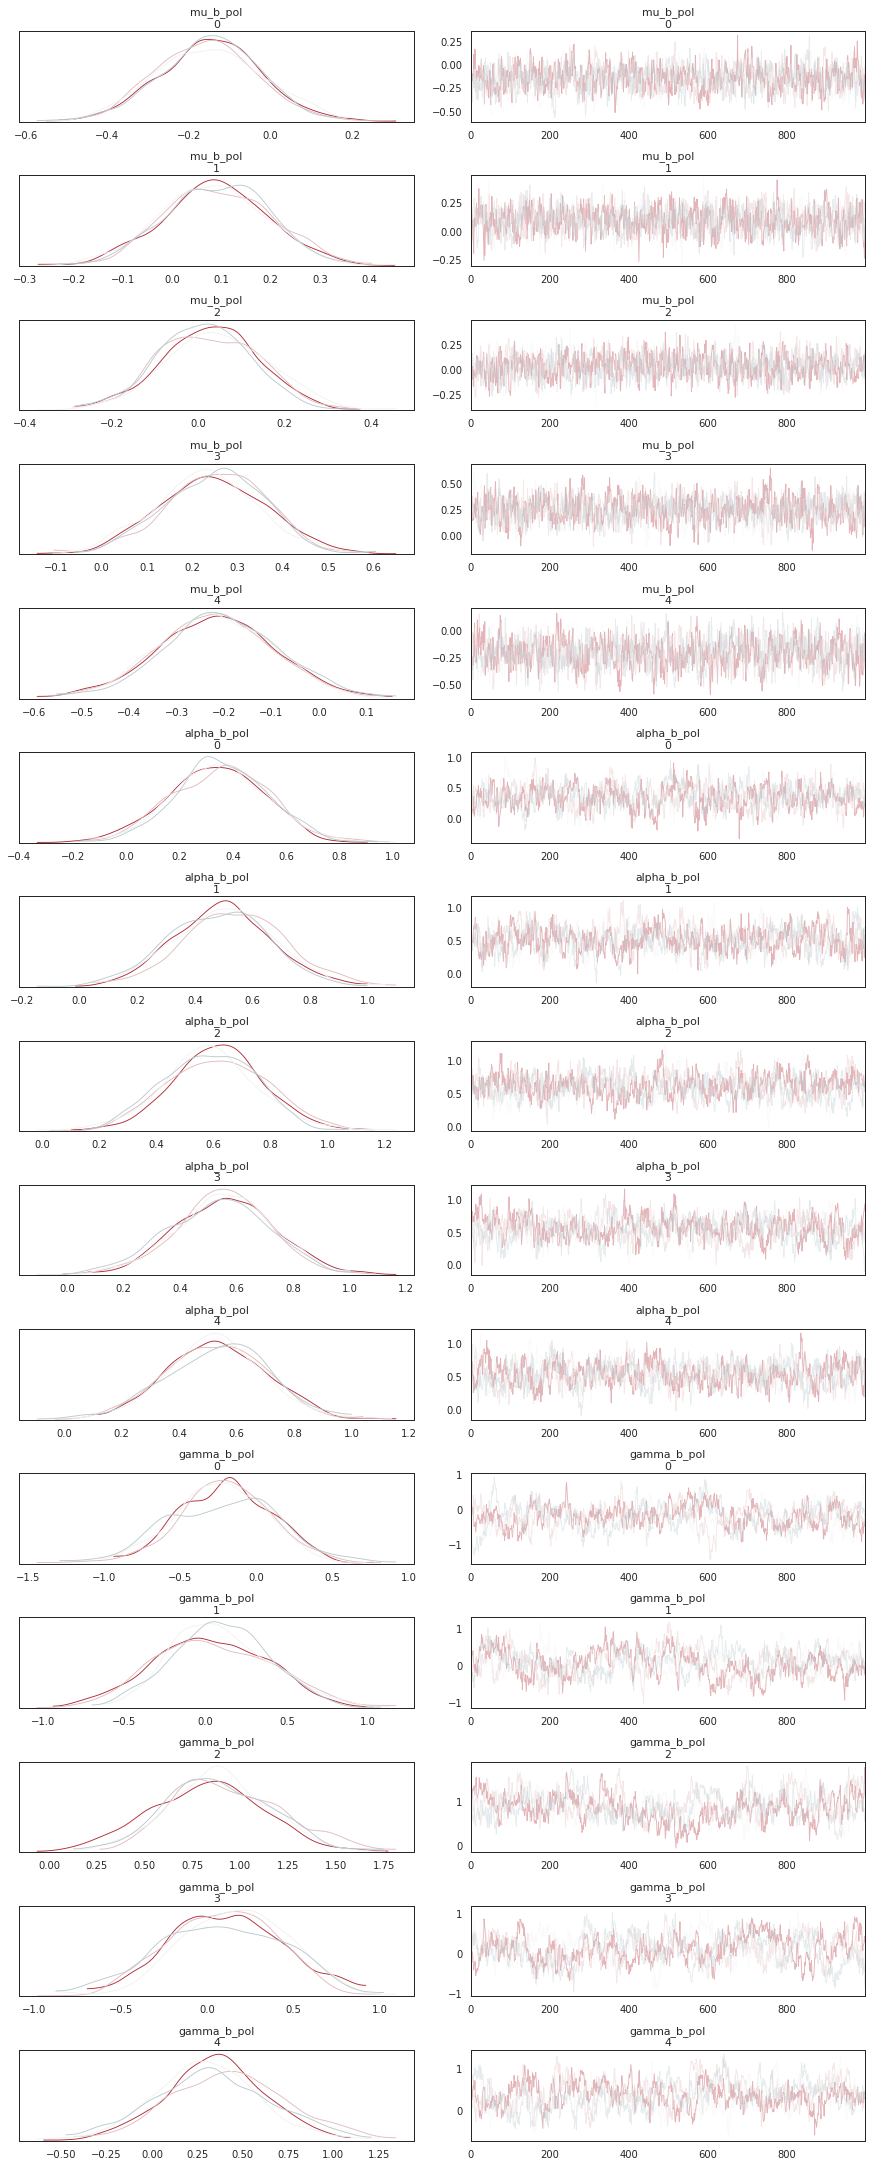

In [22]:
az.plot_trace(belief_samples, 
              var_names=['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol']);

In [23]:
print('Generating tables, figures and saving....')
extracted_belief_samples = belief_samples.extract(['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol','mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol','theta'])
variables = ['alpha_a_pol', 'gamma_a_pol', 'mu_a_pol', 
             'alpha_b_pol', 'gamma_b_pol', 'mu_b_pol','theta' ]
# extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_belief_samples, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_agent.tex', latex_string)


Generating tables, figures and saving....
\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_a\_pol & -0.269252 &  0.130168 & -0.479491 & -0.269021 & -0.062178 \\
 alpha\_a\_pol & -0.783844 &  0.142231 & -1.012470 & -0.782194 & -0.558682 \\
 alpha\_a\_pol & -0.585699 &  0.134351 & -0.800288 & -0.586573 & -0.373097 \\
 alpha\_a\_pol & -0.764578 &  0.144110 & -0.995813 & -0.764956 & -0.528829 \\
 alpha\_a\_pol & -0.284812 &  0.134678 & -0.502676 & -0.285012 & -0.067078 \\
 gamma\_a\_pol &  2.863933 &  0.291977 &  2.422375 &  2.847481 &  3.350477 \\
 gamma\_a\_pol &  2.695599 &  0.299669 &  2.228147 &  2.689664 &  3.188821 \\
 gamma\_a\_pol &  1.742466 &  0.251603 &  1.340206 &  1.737695 &  2.144788 \\
 gamma\_a\_pol &  2.295903 &  0.292094 &  1.842612 &  2.282560 &  2.790027 \\
 gamma\_a\_pol &  2.557794 &  0.274882 &  2.115510 &  2.563331 &  2.993465 \\
    mu\_a\_pol &  1.029514 &  0.091495 &  0.885060 &  1.0

<h3>Posterior Predictive</h3>

In [24]:
#Some of those chains look a bit autocorrelated but converged, so let's look at the ppd. 

belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                           CHAIN_OUTPUT, 
                                        'belief')

belief_samps = belief_samples.extract()


/home/joseph/github/Collective-wisdom-in-polarized-groups/src/posterior_predictive.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/Collective-wisdom-in-polarized-groups/src/posterior_predictive.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)


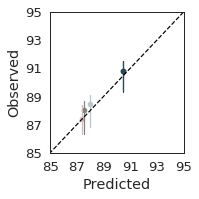

In [25]:
from src.posterior_predictive import plot_predicted_vs_observed_belief_model
#plt.savefig('../Graphs/PredictedVsObserved.pdf', fmt='.pdf',dpi=1500)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)

sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(3,3))
plot_predicted_vs_observed_belief_model(belief_samps, exp_1_data);
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedBelief.pdf', fmt='pdf')


/home/joseph/github/Collective-wisdom-in-polarized-groups/src/posterior_predictive.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/Collective-wisdom-in-polarized-groups/src/posterior_predictive.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)


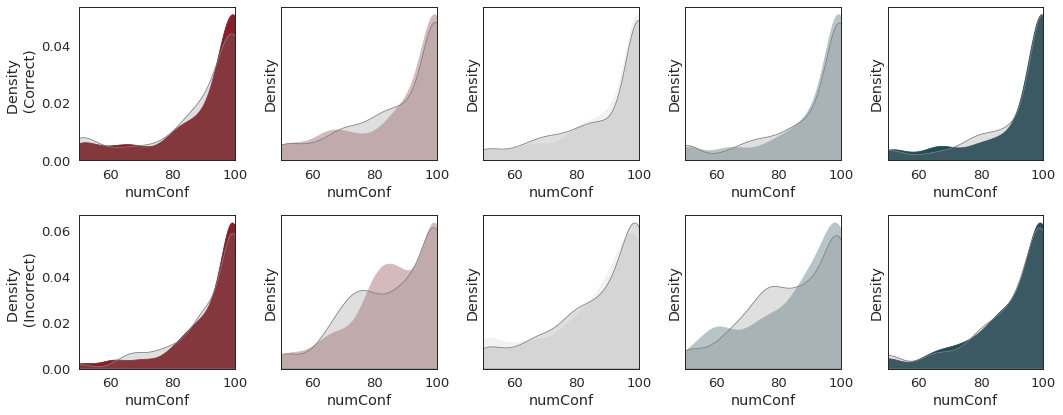

In [26]:
from src.posterior_predictive import plot_belief_model_distributions

exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
sns.set_context()
plt.figure(figsize=(15,6))
plot_belief_model_distributions(exp_1_data,belief_samps)
plt.savefig(FIGURE_OUTPUT+'PosteriorPredictiveConfidenceDistributions.pdf', fmt='pdf')



<h2>Agent model of social influence</h2>

<h3>Model for Initially Correct Participants</h3>

<h4>Compile and Sample</h4>

Sampling agent model of social influence


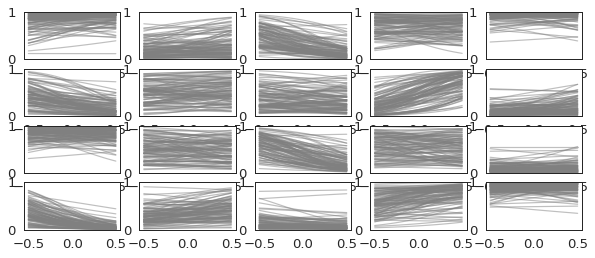

In [27]:
print("Sampling agent model of social influence")
plt.figure(figsize=(10, 4))
for idx in range(20):
    plt.subplot(4,5,idx+1)
    alpha_p = np.random.normal(0,2);
    b_conf_p = np.random.normal(0,2);
    b_socConf_p = np.random.normal(0,2);

    alpha = np.random.normal(alpha_p, 1, 100);
    b_conf = np.random.normal(b_conf_p, 1, 100);

    x = np.linspace(-.5,.5, 100)
    y_sim = np.array([alpha + b_conf * item for item in x])
    plt.plot(x,ilogit(y_sim),color='grey',alpha=.5)
    plt.ylim(0,1)


In [28]:
switch_model = pystan.StanModel(file='./src/switch_model.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68dd4818b050fd456b35236fb514ed4e NOW.


In [29]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_correct, _= format_stan_data_switch(exp_1_data,correct=True)

switch_samples_correct = switch_model.sampling(data=stan_model_data_correct)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4>Evaluate MCMC</h4>

/home/joseph/github/Collective-wisdom-in-polarized-groups/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


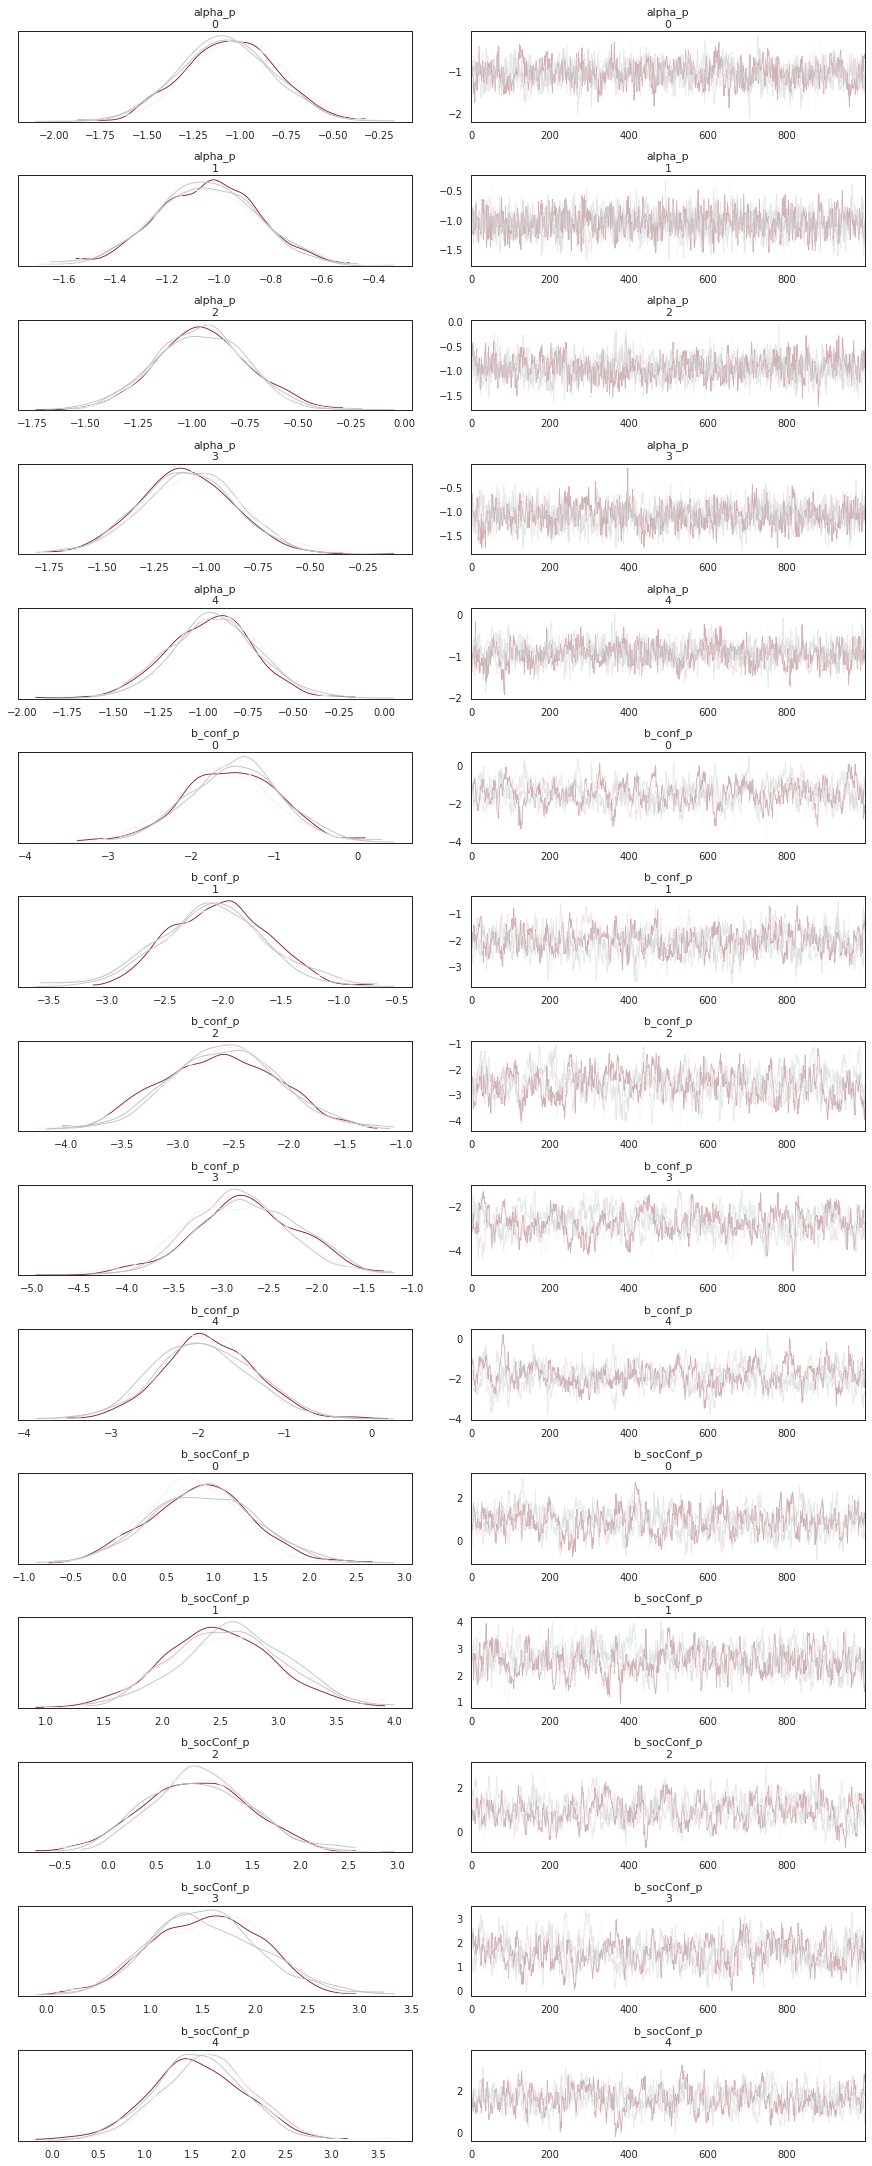

In [30]:
import arviz as av
#Extract samples
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_correct, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_correct');

#Plot chains
av.plot_trace(switch_samples_correct, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Plotting Social influence figures, making tables and saving...


Text(0.5, 1.0, 'Initially \ncorrect')

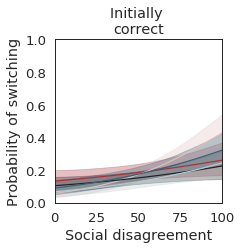

In [31]:
print('Plotting Social influence figures, making tables and saving...')
from src.exp_1_figures import plot_fig1cd

stan_model_data_correct, df= format_stan_data_switch(exp_1_data,correct=True)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)

plt.title('Initially \ncorrect')




In [32]:
#Make table 
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_correct, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_correct.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -1.058239 &  0.250831 & -1.460011 & -1.059113 & -0.659481 \\
     alpha\_p & -1.049217 &  0.200408 & -1.370474 & -1.046542 & -0.721270 \\
     alpha\_p & -0.955852 &  0.214065 & -1.300456 & -0.957290 & -0.614285 \\
     alpha\_p & -1.079646 &  0.229074 & -1.443712 & -1.083527 & -0.708155 \\
     alpha\_p & -0.941698 &  0.238153 & -1.330061 & -0.938088 & -0.566578 \\
    b\_conf\_p & -1.519097 &  0.568378 & -2.446074 & -1.505751 & -0.616019 \\
    b\_conf\_p & -2.078485 &  0.456825 & -2.791885 & -2.076905 & -1.345450 \\
    b\_conf\_p & -2.599021 &  0.517875 & -3.435316 & -2.593012 & -1.777314 \\
    b\_conf\_p & -2.777275 &  0.543924 & -3.635563 & -2.787021 & -1.897076 \\
    b\_conf\_p & -1.919601 &  0.546541 & -2.786504 & -1.934063 & -1.047859 \\
 b\_socConf\_p &  0.854888 &  0.536210 &  0.004413 &  0.854576 &  1.715814 \\
 b\_socConf\_p &  2.567517

<h3>Model for Initially Incorrect particpants</h3>

<h4>Compile and Sample</h4>

In [33]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)

switch_samples_incorrect = switch_model.sampling(data=stan_model_data_incorrect)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4> Evaluate MCMC </h4>

/home/joseph/github/Collective-wisdom-in-polarized-groups/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


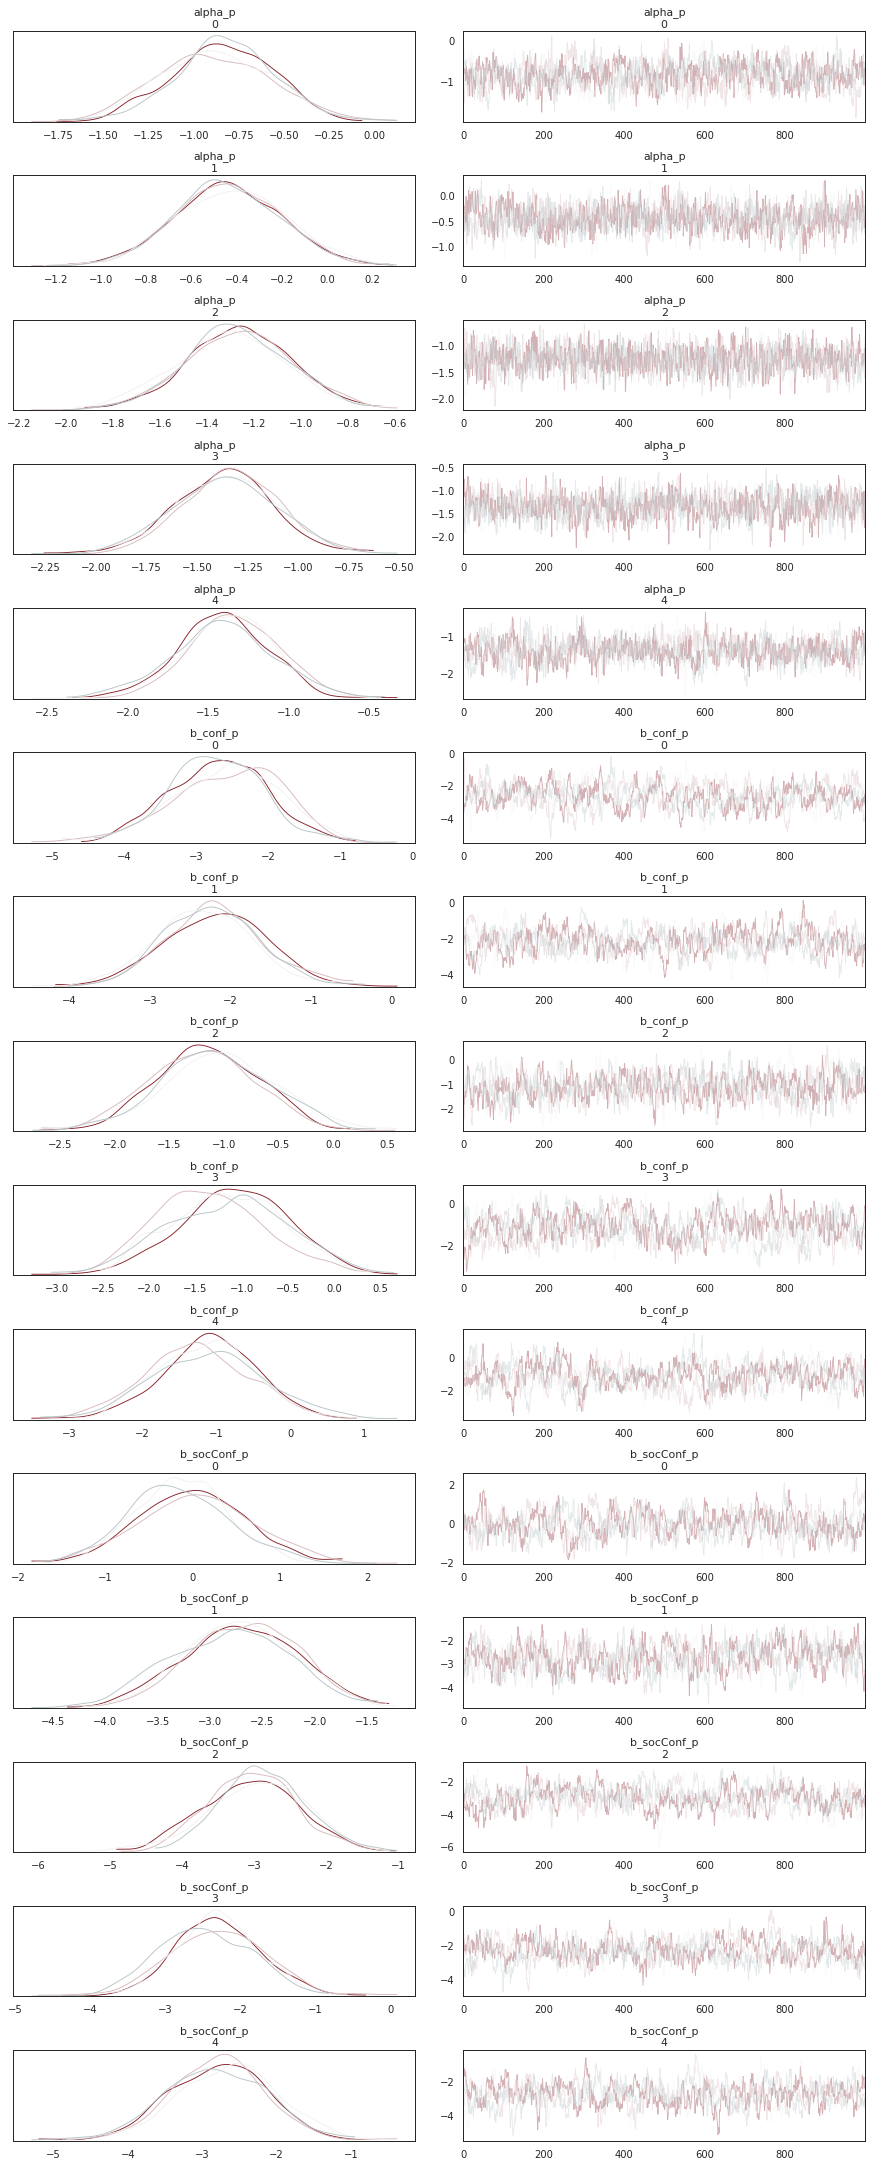

In [34]:
import arviz as av
#Extract samples
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_incorrect, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_incorrect');
#Plot chains
av.plot_trace(switch_samples_incorrect, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Text(0.5, 1.0, 'Initially \nincorrect')

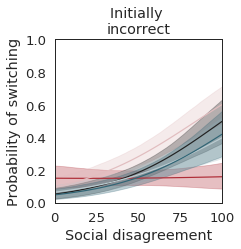

In [35]:
from src.exp_1_figures import plot_fig1cd

stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')




In [36]:
#Make table
from src.utils import make_latex_table
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_incorrect, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_incorrect.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -0.856401 &  0.293142 & -1.331904 & -0.859151 & -0.393526 \\
     alpha\_p & -0.436009 &  0.234323 & -0.806798 & -0.440039 & -0.063007 \\
     alpha\_p & -1.274897 &  0.226389 & -1.642532 & -1.273952 & -0.912082 \\
     alpha\_p & -1.355052 &  0.248881 & -1.757978 & -1.351464 & -0.962027 \\
     alpha\_p & -1.380678 &  0.291246 & -1.856571 & -1.380283 & -0.930134 \\
    b\_conf\_p & -2.640978 &  0.703473 & -3.800600 & -2.616498 & -1.550107 \\
    b\_conf\_p & -2.232338 &  0.620897 & -3.198128 & -2.236317 & -1.221270 \\
    b\_conf\_p & -1.113230 &  0.504657 & -1.919915 & -1.118522 & -0.306012 \\
    b\_conf\_p & -1.183274 &  0.622468 & -2.163137 & -1.177291 & -0.170228 \\
    b\_conf\_p & -1.143895 &  0.702021 & -2.256833 & -1.132704 & -0.012271 \\
 b\_socConf\_p & -0.061503 &  0.600017 & -1.002889 & -0.076325 &  0.937055 \\
 b\_socConf\_p & -2.724381

<h3> Posterior Preditive Checks</h3>

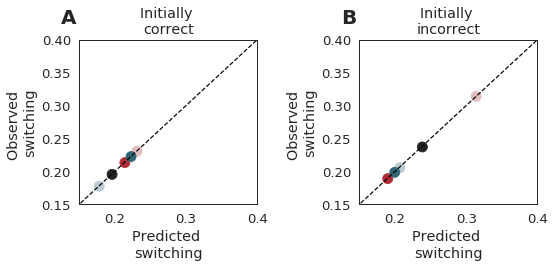

In [37]:
from src.exp_1_figures import plot_switch_predicted_acuracy
plt.figure(figsize=(8,4))
plt.subplot(121)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=True)
plot_switch_predicted_acuracy(df, switch_samples_correct, correct=True)
plt.title('Initially \ncorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.subplot(122)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)
plot_switch_predicted_acuracy(df, switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedSwitch.pdf', fmt='pdf')


<h2>Figure 1</h2>

Generating figure 1


/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


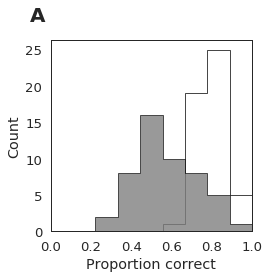

In [38]:
print("Generating figure 1")
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


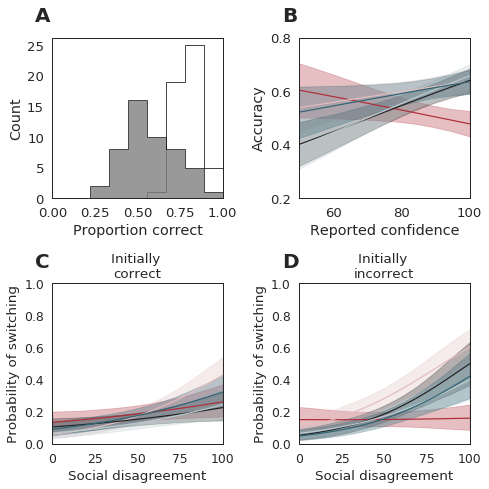

In [39]:
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()


plt.subplot(222)
sns.set_context('paper', font_scale=1.4)
model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT, 
                                                            'confidence_accuracy_logit')
#Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
#Get the data in the format the model wants to see it. 
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
plot_figure1b(extracted_samples_logistic, stan_data_logistic)
ax=plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(223)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=True)
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)
plt.title('Initially \ncorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(224)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect,correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.savefig(FIGURE_OUTPUT+'Figure1.pdf', fmt='pdf')


<h1> Simulation Study</h1>

<h2>Load Models</h2>

In [5]:
switch_samples_correct_model, switch_samples_correct = load_model(MODEL_OUTPUT,
                                                                  CHAIN_OUTPUT,
                                                                  'switch_samples_correct')
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p',
                                                                   'b_conf_p',
                                                                   'b_socConf_p'])


switch_samples_incorrect_model, switch_samples_incorrect = load_model(MODEL_OUTPUT,
                                                                      CHAIN_OUTPUT,
                                                                      'switch_samples_incorrect')
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p',
                                                                       'b_conf_p',
                                                                       'b_socConf_p'])


belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                          CHAIN_OUTPUT,
                                          'belief')

extracted_belief_samples = belief_samples.extract()

<h2>Simulate</h2>

In [6]:
print('Running simulations... grab a cup of coffee.')
from pandarallel import pandarallel
import itertools as it
from src.simulation_study import run_single
from tqdm.auto import tqdm
from multiprocessing import cpu_count

tqdm.pandas(desc="my bar!")

pandarallel.initialize(nb_workers=cpu_count(), progress_bar=True)


dat_dict ={'proportions':[[75,50,30,50,75]],
             'p':[.5,.75,.98],
             'diff':np.linspace(.40,.6,20),
             'repeat':np.arange(2000),
             'N':[500],
             'lean':np.array(['right','left',False])}

def get_combinations_dataframe(dd):
    allNames = sorted(dd)
    combinations = it.product(*(dd[Name] for Name in allNames))
    dat = pd.DataFrame(list(combinations), columns=allNames)
    return(dat)

df = get_combinations_dataframe(dat_dict)
    
run_row = lambda dat : run_single(dat['p'],
            dat['diff'],
            dat['N'],
            dat['proportions'],
            dat['lean'],
            extracted_belief_samples,
            extracted_switch_samples_incorrect,
            extracted_switch_samples_correct)

simulation_results = df.parallel_apply(run_row, axis=1)



Running simulations... grab a cup of coffee.
INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<h3>Store Data</h3>

In [7]:
# df['correct_final'] = np.array(np.hstack(simulation_results))
sim_results = np.vstack(simulation_results)
df['correct_final'] = sim_results[:,0]
df['correct_start'] = sim_results[:,0]
df.to_csv(SIMULATION_DATA)



<h3>Load Data</h3>

In [11]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()
simulation_results.shape

(360000, 11)

<h3>Plot Results</h3>

In [12]:
from scipy import stats
def get_bionomial_ci(n=100,k=200,res=1000,q = [5.5, 94.5]):
    p_grid = np.linspace(0,1,res)
    likelihood = stats.binom(k, p_grid).pmf(n)
    prior = np.ones(res)
    posterior=likelihood*prior
    posterior = posterior/np.sum(posterior)

    samples = np.random.choice(p_grid, p=posterior,size=res)
    return(np.percentile(samples, q=q))



def plot_simulation_results(temp,N=500): 
    grouped =  temp.groupby(['p', 'lean','diff']).sum().reset_index()
    grouped.head()
    #plt.scatter(grouped['diff'], grouped['correct_majority'])
    samples_per_difficulty = grouped['total'].values[0]

    ci = np.array([get_bionomial_ci(n=item,k=samples_per_difficulty) for item in grouped['correct_majority'].values])
    pal = sns.color_palette("Greens", n_colors=5)
    grouped['lower'] = ci[:,0]
    grouped['upper'] = ci[:,1]
    ps = [.5,.75,.98]
    for idx in range(3):
        temp = grouped[grouped.p==ps[idx]]
        t1 = temp.groupby(['diff']).mean().reset_index()
        plt.plot(t1['diff'].values, 
                 t1['correct_majority'].values/samples_per_difficulty, 
                 color=pal[idx+2])

        plt.fill_between(t1['diff'].values, t1['lower'], t1['upper'],color=pal[idx+2],alpha=.3)
        head_length = .05
    plt.plot(t1['diff'].values, 
             1-stats.binom(N,t1['diff'].values).cdf(N/2),
             ls='--', 
             color='grey',lw=2)
    plt.ylabel('Collective Accuracy') 
    plt.xlabel('Initial proportion correct')

def add_arrow(dat):

    temp1 = dat[dat.p==.98]
    t1 = temp1.groupby(['diff']).mean().reset_index()
    temp2 = dat[dat.p==.5]
    t2 = temp2.groupby(['diff']).mean().reset_index()
    samples_per_difficulty = t2['total'].values[0]

    diff = t1['correct_majority']/samples_per_difficulty - t2['correct_majority']/samples_per_difficulty

    maxdiff = np.argmax(np.abs(diff))
    print(t2['diff'][maxdiff])
    ax = plt.gca()
    print(t1.shape)


    head_length = .05
    ax.arrow(t2['diff'][maxdiff],
             t2['correct_majority'][maxdiff]/samples_per_difficulty, 
             0,
             t1['correct_majority'][maxdiff]/samples_per_difficulty- \
             t2['correct_majority'][maxdiff]/samples_per_difficulty + \
             head_length,
            head_width=0.015, head_length=head_length, fc='grey', ec='grey')



INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


0.5052631578947369
(20, 9)


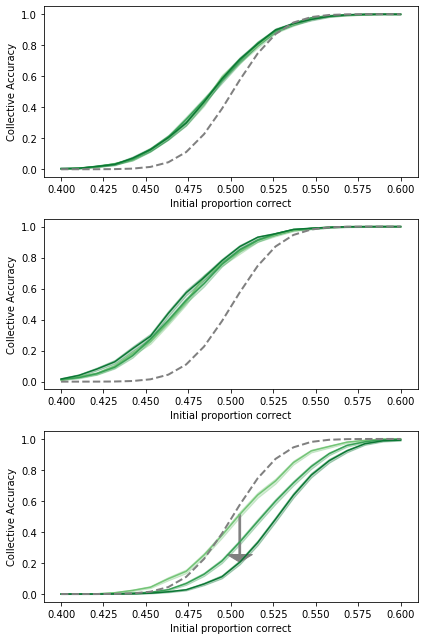

In [13]:
plt.figure(figsize=(6,9))
plt.subplot(311)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
plt.tight_layout()
plt.subplot(312)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])
plt.tight_layout()
plt.subplot(313)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])
plt.tight_layout()



<h1>Experiment 2</h1>

<h2>Model compilation and sampling</h2>

<h3>Prior Predictive Simulation</h3>

Sampling model for Experiment 2


/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

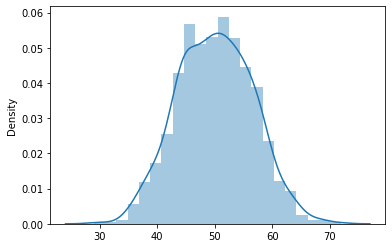

<Figure size 432x288 with 0 Axes>

In [14]:
print('Sampling model for Experiment 2')
alpha = np.random.normal(0,.2,1000);

y = np.random.binomial(100, ilogit(alpha));
sns.distplot(y)
plt.figure()


In [15]:

def format_stan_data_exp2(exp_2_data):
    false_exp2_data = exp_2_data[exp_2_data.answer==False]
    false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
    N = false_exp2_data.shape[0]
    p = 1*(false_exp2_data.p_recode.values)
    cond = false_exp2_data['cond_recode'].values+1
    y = 1*(false_exp2_data['social_correct'].values)
    false_exp2_data['cond_recode']
    pd.Categorical(false_exp2_data['cond_recode'])
    grouped_exp2 = false_exp2_data.groupby(['state', 'cond_recode', 'p_recode']).sum().reset_index()
    
    
    state_data = dict(y=grouped_exp2['social_correct'].astype('int').values,
                        N = grouped_exp2.shape[0],
                        count=grouped_exp2['count'].astype('int').values,
                        cond = grouped_exp2['p_recode'].values *3 + \
                           grouped_exp2['cond_recode'].astype('int').values+1)
    return state_data, false_exp2_data
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
  

<ipython-input-15-5f9dd8cbb5e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])


In [16]:
#from src.stan_data_format import format_stan_data_exp2
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
exp2_model = pystan.StanModel(file='./src/experiment_2_validation.stan')


<ipython-input-15-5f9dd8cbb5e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1440b0a435e2ad1856dabafc7c770426 NOW.


In [17]:
exp2_samples = exp2_model.sampling(data=stan_data_exp2)

<h2>Evaluate MCMC</h2

In [18]:
exp2_samples

Inference for Stan model: anon_model_1440b0a435e2ad1856dabafc7c770426.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   0.25  9.5e-4   0.07   0.11    0.2   0.25   0.29   0.38   5276    1.0
alpha[2]    0.2  9.1e-4   0.07   0.07   0.16    0.2   0.25   0.33   5429    1.0
alpha[3]   0.35  9.2e-4   0.07   0.22   0.31   0.35    0.4   0.48   5367    1.0
alpha[4]    0.3  8.9e-4   0.07   0.17   0.26    0.3   0.34   0.43   5387    1.0
alpha[5]   0.19  9.1e-4   0.06   0.07   0.15   0.19   0.23   0.32   5061    1.0
alpha[6]   0.11 10.0e-4   0.07  -0.01   0.07   0.11   0.16   0.24   4524    1.0
lp__      -3359    0.04   1.77  -3363  -3360  -3358  -3357  -3356   2019    1.0

Samples were drawn using NUTS at Thu Oct  7 16:47:40 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

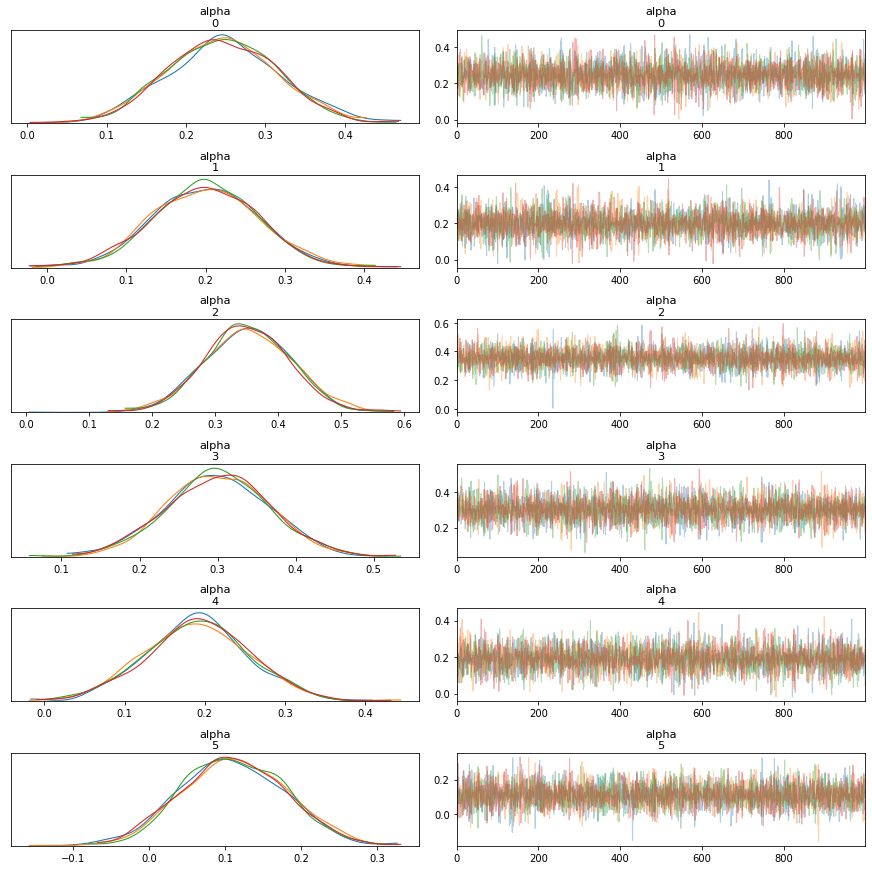

In [19]:
az.plot_trace(exp2_samples);

Plotting and saving figures, table...
-0.05921525007310282
[-0.0959763  -0.02267625]


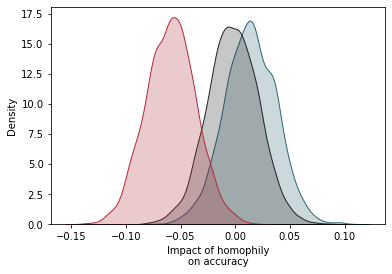

In [20]:
print('Plotting and saving figures, table...')
extracted_exp2 = exp2_samples.extract()


def plot_fig2F(exp2_samples):

    pal = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='dark')
    pal[1] = pal2[1]

    pal_order = [2,1,0]


    for idx in range(3):
        sns.kdeplot(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]),
                    shade=True, 
                    color=pal[pal_order[idx]])

    print(np.mean(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx])))
    print(np.percentile(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]), q=[5.5,94.5]))

    plt.xlabel('Impact of homophily\non accuracy')
    plt.ylabel('Density')

plot_fig2F(extracted_exp2)

<h2>Coefficient Table</h2>

In [21]:
variables = ['logit_alpha']
extracted_exp2['logit_alpha'] = ilogit(extracted_exp2['alpha'])
latex_string = make_latex_table(extracted_exp2, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'experiment2.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 logit\_alpha &  0.561135 &  0.016983 &  0.534264 &  0.561091 &  0.588821 \\
 logit\_alpha &  0.549837 &  0.016553 &  0.523768 &  0.549895 &  0.576021 \\
 logit\_alpha &  0.587050 &  0.016273 &  0.561361 &  0.586831 &  0.612404 \\
 logit\_alpha &  0.574596 &  0.015974 &  0.548584 &  0.574632 &  0.600399 \\
 logit\_alpha &  0.547589 &  0.015949 &  0.521804 &  0.547620 &  0.573358 \\
 logit\_alpha &  0.527834 &  0.016675 &  0.501655 &  0.527444 &  0.555046 \\
\bottomrule
\end{tabular}



<h1>Figure 2</h1>

In [22]:
from PIL import Image

def make_square(im, min_size=1000, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im



In [23]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()

Unnamed: 0    N  diff   lean    p           proportions  repeat  \
0           0  500   0.4  right  0.5  [75, 50, 30, 50, 75]       0   
1           1  500   0.4  right  0.5  [75, 50, 30, 50, 75]       1   
2           2  500   0.4  right  0.5  [75, 50, 30, 50, 75]       2   
3           3  500   0.4  right  0.5  [75, 50, 30, 50, 75]       3   
4           4  500   0.4  right  0.5  [75, 50, 30, 50, 75]       4   

   correct_final  correct_start  total  correct_majority  
0          0.444          0.444    1.0             False  
1          0.410          0.410    1.0             False  
2          0.428          0.428    1.0             False  
3          0.460          0.460    1.0             False  
4          0.460          0.460    1.0             False

0.5052631578947369
(20, 9)
0.5870495849053715


<ipython-input-15-5f9dd8cbb5e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])


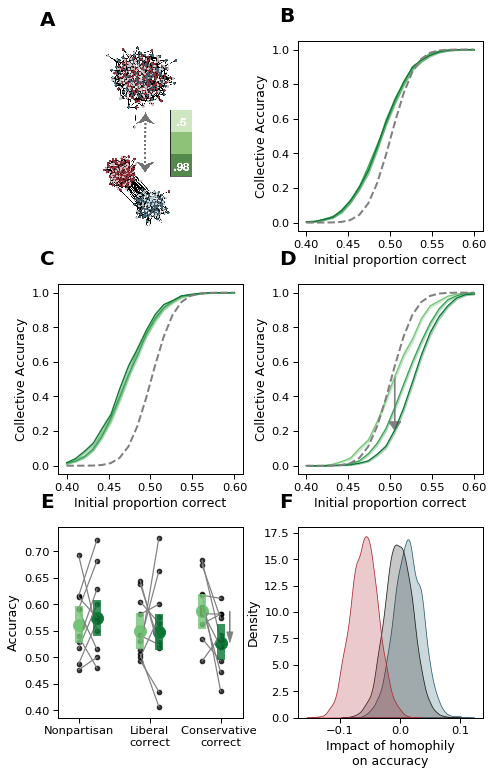

In [24]:
from src.exp_2_figures import plot_fig2E, plot_fig2F

sns.set_context('paper', font_scale=1.3)
plt.subplots(3,2,figsize=(7,10.5))


plt.subplot(322)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
ax = plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')


plt.subplot(321)
test_image = Image.open('./dat/network_img.png')
new_image = make_square(test_image)
plt.imshow(new_image)


ax = plt.gca()

ax.axis('off')
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')

plt.tight_layout()
plt.subplot(323)
ax = plt.gca()

ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])

plt.tight_layout()
plt.subplot(324)
ax = plt.gca()

ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])



plt.subplot(3,2,5)
ax = plt.gca()
ax.text(-0.1, 1.1, 'E', transform=ax.transAxes, 
        size=20, weight='bold')
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
plot_fig2E(exp2_data, exp2_samples)


plt.subplot(3,2,6)
ax = plt.gca()
ax.text(-0.1, 1.1, 'F', transform=ax.transAxes, 
        size=20, weight='bold')
plot_fig2F(exp2_samples)
plt.savefig(FIGURE_OUTPUT+'Figure2.pdf',dpi=1500, fmt='pdf')

<h1>Conceptual model</h1>

<h2>Define model and estimate parametrs from data</h3>

In [25]:
print('Computing conceptual model.....')
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

Computing conceptual model.....


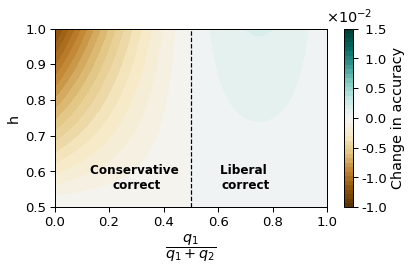

In [26]:
def get_prob(q1, q2, p, a11, g11, a22, g22, a21, g21, a12, g12):
    bb = p*(q1*(1-q1)*(a11-g11)) + (1-p) * (q2*a21*(1-q1)-g21*q1*(1-q2))

    cc = p*(q2*(1-q2)*(a22-g22)) + (1-p) * (q1*a12*(1-q2)-g12*q2*(1-q1))
    return (q1+q2+bb+cc)/2


#1=Libera
a11 = .25
g11 = .2
a12 = .2
g12 = .2

#2=Conservative
a22 = .2
g22 = .2
a21 = .25
g21 = .2



p = np.linspace(0.5, 1.0, 500)
q = np.linspace(0,1,500)

X, Y = np.meshgrid(q, p)
sns.set_context('paper', font_scale=1.5)
sns.set_palette(sns.diverging_palette(100, 280, s=85, l=25, n=20))

Z = get_prob(X, (1-X), Y, a11, g11, a22, g22, a21, g21, a12, g12) - \
    get_prob(X, (1-X), .5, a11, g11, a22, g22, a21, g21, a12, g12) 
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z*100,levels=np.linspace(-1.5, 1.5, 41),cmap=plt.get_cmap('BrBG'))
cb = fig.colorbar(cp,ticks=[-1.5,-1,-.5,0,.5,1.0,1.5]) # Add a colorbar to a plot
cb.ax.set_title(r'$\times 10^{-2}$')

cb.set_label('Change in accuracy')
cb.ax.set_yticklabels(['-1.0','-1.0','-0.5',' 0.0',' 0.5', ' 1.0', ' 1.5']) 
ax.set_xlabel('$\dfrac{q_1}{q_1+q_2}$')
ax.set_ylabel('h')
plt.plot([.5,.5], [.5,1], ls='--', color='k')
plt.tight_layout()

ax.text(0.3, .1, 'Conservative \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
ax.text(0.7, .1, 'Liberal \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
plt.savefig(FIGURE_OUTPUT+'Figure3.pdf',dpi=1500, fmt='pdf')

<h1>Experiment 3</h1>

<h2>Format data</h2>

In [27]:
EXPERIMENT_3 = './dat/raw/Experiment3.csv'
data, melted  = clean_exp3(pd.read_csv(EXPERIMENT_3))
melted.head()

conf  answer      question  correct  correct_conf  incorrect_conf  \
2  0.22    True  Russia_False    False      74.44898       82.278146   
3  0.88    True  Russia_False    False      74.44898       82.278146   
6  0.28   False  Russia_False     True      74.44898       82.278146   
7  0.92    True  Russia_False    False      74.44898       82.278146   
9  0.60    True  Russia_False    False      74.44898       82.278146   

   difficulty  pol_recode  DEM_1              DEM_2  ...       BSS WSS  EIS  \
2    0.393574           3  25-34            Liberal  ...  1.000000   3  1.4   
3    0.393574           0  25-34  Very Conservative  ...  2.333333   0  2.4   
6    0.393574           2  18-24           Moderate  ...  0.000000   1  2.0   
7    0.393574           1  55-64       Conservative  ...  1.333333   4  2.8   
9    0.393574           4  18-24       Very Liberal  ...  1.333333   4  0.8   

   HBS  NUMS  RIS                                CintID  edu_recode id_recode  \
2    4     3  2.0  28bed585-e303-9564-5492-e39545a3d55b           3        73   
3    2     0  1.6  11587f4b-61e3-301d-b25c-4973334bd79d           4        36   
6    0     1  2.0  f0319e12-096b-b176-db05-a81a1422bcc6           0       467   
7    2     3  2.0  811ae5ae-103d-a896-f0b9-d331c393a673           2       254   
9    2     3  1.2  7a542be2-4bf1-2fd3-bef5-1d7f0785fc36           2       235   

   question_code  
2             23  
3             23  
6             23  
7             23  
9             23  

[5 rows x 22 columns]

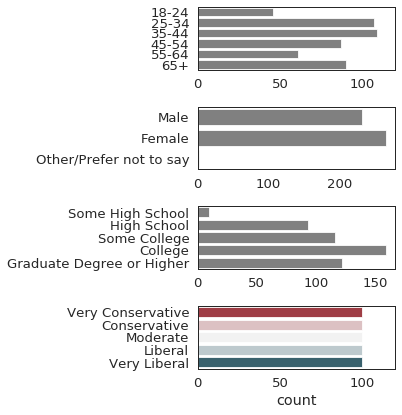

In [28]:
from src.exp_3_figures import plot_exp3_demographics
plot_exp3_demographics(data)
plt.savefig('./out/figures/Experiment3Demographics.pdf',transparent=True)


<h2>Load model</h2>

In [29]:
print('Sampling experiment 3 model...')
temp_model =  pystan.StanModel(file='./src/exp3_cchbm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_546428ea88b1ceed52bd3eafb395e0d1 NOW.


Sampling experiment 3 model...


In [30]:
from src.stan_data_format import format_stan_data_exp3
exp3_stan_df = format_stan_data_exp3(melted)

<h3> Prior Predictive simulation</h3>

In [31]:
prior_samples = temp_model.sampling(data=exp3_stan_df, algorithm='Fixed_param')

(0.5, 1)

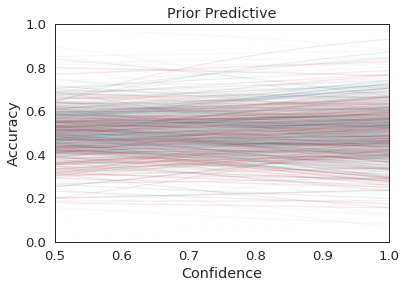

In [32]:
#Fit MLE estimates for regressions from the prior predictive. 
#It's a bit loose, but not out of line with what we saw in exp1, and we want 
#a lot of relationship flexibilty for questions and subjects. seems reasonable. 
from sklearn.linear_model import LogisticRegression
for idx in range(100):
    temp = melted.copy()
    chain = np.random.choice(4000)
    y_prior = prior_samples['y_prior'][chain,:]
    temp['y_prior'] = y_prior

    for idx in range(5):
        t = temp[temp['pol_recode']==idx]
        x = t['conf'].values

        clf = LogisticRegression(random_state=0).fit(x.reshape(-1, 1), t['y_prior'])

        xtemp = np.linspace(.5,1,100).reshape(-1, 1)
        ytemp = clf.predict_proba(xtemp)
        plt.plot(xtemp,ytemp,alpha=.1)
plt.title('Prior Predictive')
plt.xlabel("Confidence")
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.xlim(.5,1)

<h3>Sample model with political leaning for individual effects</h3>

In [33]:
exp3_model = pystan.StanModel(
    file='./src/exp3_cchbm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_546428ea88b1ceed52bd3eafb395e0d1 NOW.


In [34]:
from src.stan_data_format import format_stan_data_exp3
exp3_stan_df = format_stan_data_exp3(melted)

In [35]:
cchbml_samples = exp3_model.sampling(data=exp3_stan_df,)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


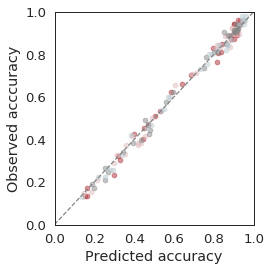

In [38]:
from src.exp_3_figures import plot_posterior_predictive_exp3
plot_posterior_predictive_exp3(melted, cchbml_samples)
plt.xlabel('Predicted accuracy')
plt.ylabel('Observed acccuracy')
plt.tight_layout()
plt.savefig('./out/figures/posterior_predictive_exp3.pdf')

In [39]:
az.summary(cchbml_samples, var_names=['alpha','beta','beta_q','gamma']).sort_values('r_hat',ascending=False)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha         0.345  0.602  -0.717    1.497      0.018    0.012    1178.0   
beta_q[7,2]   0.694  0.621  -0.513    1.824      0.010    0.007    3625.0   
beta_q[7,0]   1.195  0.664   0.007    2.503      0.011    0.008    3344.0   
beta_q[6,31]  1.566  0.734   0.160    2.934      0.011    0.008    4263.0   
beta_q[6,30]  1.413  0.809  -0.122    2.902      0.015    0.011    2941.0   
...             ...    ...     ...      ...        ...      ...       ...   
beta_q[3,11]  0.278  0.389  -0.420    1.059      0.008    0.005    2597.0   
beta_q[3,10]  0.372  0.374  -0.222    1.137      0.007    0.005    3151.0   
beta_q[3,9]   0.169  0.368  -0.508    0.908      0.006    0.005    3352.0   
beta_q[3,8]   0.324  0.384  -0.322    1.114      0.007    0.005    2756.0   
gamma[1,4]    0.135  0.249  -0.331    0.603      0.007    0.005    1310.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
alpha         1178.0    1188.0    2159.0    1.0  
beta_q[7,2]   3625.0    3762.0    3364.0    1.0  
beta_q[7,0]   3216.0    3338.0    3719.0    1.0  
beta_q[6,31]  4081.0    4267.0    3573.0    1.0  
beta_q[6,30]  2882.0    2975.0    3212.0    1.0  
...              ...       ...       ...    ...  
beta_q[3,11]  2597.0    2541.0    3204.0    1.0  
beta_q[3,10]  3151.0    3008.0    3531.0    1.0  
beta_q[3,9]   3296.0    3314.0    3483.0    1.0  
beta_q[3,8]   2756.0    2679.0    3432.0    1.0  
gamma[1,4]    1310.0    1311.0    2034.0    1.0  

[332 rows x 11 columns]

In [40]:
az.summary(cchbml_samples,var_names=['beta_q','beta_s','gamma']).sort_values('r_hat',ascending=False).head()


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_q[0,0]   0.584  0.655  -0.601    1.884      0.009    0.008    4834.0   
beta_s[1,72]  0.258  0.260  -0.202    0.787      0.007    0.005    1488.0   
beta_s[1,70]  0.199  0.261  -0.317    0.655      0.007    0.005    1400.0   
beta_s[1,69]  0.246  0.254  -0.230    0.730      0.007    0.005    1442.0   
beta_s[1,68]  0.140  0.261  -0.350    0.644      0.007    0.005    1485.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta_q[0,0]   3315.0    4874.0    3028.0    1.0  
beta_s[1,72]  1488.0    1492.0    2054.0    1.0  
beta_s[1,70]  1400.0    1414.0    2091.0    1.0  
beta_s[1,69]  1442.0    1443.0    2001.0    1.0  
beta_s[1,68]  1485.0    1486.0    2077.0    1.0

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f59d16badf0>],
      dtype=object)

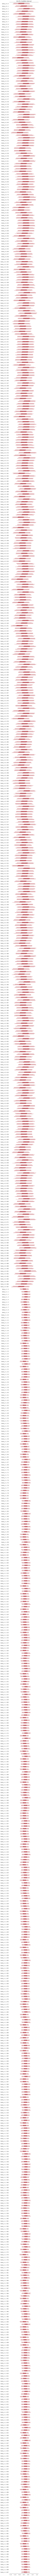

In [41]:
az.plot_forest(cchbml_samples,var_names=['beta_s'])


INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58dc0ee730>],
      dtype=object)

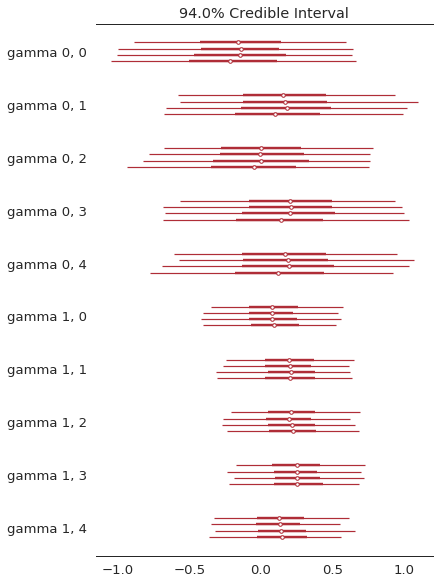

In [42]:
az.plot_forest(cchbml_samples,var_names=['gamma'])


In [43]:
az.summary(cchbml_samples,var_names=['L_Omega_q']).sort_values('r_hat',ascending=False)

/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:590: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:590: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:590: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:590: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:590: Runti

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
L_Omega_q[7,3]  0.288  0.227  -0.137    0.698      0.009    0.006     644.0   
L_Omega_q[6,5]  0.565  0.151   0.279    0.824      0.004    0.003    1174.0   
L_Omega_q[6,3]  0.264  0.232  -0.163    0.703      0.009    0.006     727.0   
L_Omega_q[9,2] -0.137  0.249  -0.627    0.309      0.010    0.007     652.0   
L_Omega_q[6,1] -0.042  0.235  -0.475    0.382      0.007    0.005    1046.0   
...               ...    ...     ...      ...        ...      ...       ...   
L_Omega_q[6,8]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[6,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[7,8]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[7,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[8,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
L_Omega_q[7,3]   644.0     664.0    1165.0   1.01  
L_Omega_q[6,5]  1174.0    1183.0    2126.0   1.01  
L_Omega_q[6,3]   727.0     732.0    1535.0   1.01  
L_Omega_q[9,2]   652.0     680.0     796.0   1.01  
L_Omega_q[6,1]  1046.0    1050.0    2104.0   1.01  
...                ...       ...       ...    ...  
L_Omega_q[6,8]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[6,9]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[7,8]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[7,9]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[8,9]  4000.0    4000.0    4000.0    NaN  

[100 rows x 11 columns]

In [44]:
print("Effect of confidence (VC-VL)")
print(np.mean(cchbml_samples['gamma'][:,1,0] - cchbml_samples['gamma'][:,1,4]))

print("89% CI")
print(np.percentile(cchbml_samples['gamma'][:,1,0] - cchbml_samples['gamma'][:,1,4], q=[5.5,94.5]))

Effect of confidence (VC-VL)
-0.0553554608748448
89% CI
[-0.27687652  0.16565417]


In [45]:
az.summary(cchbml_samples,var_names=['qm']).sort_values('r_hat',ascending=False)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
qm[0,0]   0.694  0.754  -0.779    2.039      0.011    0.009    4641.0  3395.0   
qm[0,1]   0.251  0.721  -1.020    1.646      0.012    0.010    3526.0  2402.0   
qm[6,26]  0.640  0.816  -0.852    2.228      0.011    0.011    5155.0  2791.0   
qm[6,25]  0.313  0.809  -1.235    1.748      0.013    0.011    4186.0  2697.0   
qm[6,24]  0.191  0.836  -1.461    1.639      0.012    0.013    4639.0  2045.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
qm[3,9]   0.393  0.918  -1.401    2.012      0.020    0.014    2203.0  2203.0   
qm[3,8]   0.635  0.916  -1.017    2.424      0.017    0.012    2747.0  2700.0   
qm[3,7]  -0.148  0.797  -1.695    1.291      0.013    0.012    3708.0  2312.0   
qm[3,6]   0.066  0.809  -1.467    1.509      0.013    0.012    4057.0  2283.0   
qm[9,31] -0.150  0.869  -1.871    1.425      0.009    0.013    8404.0  2096.0   

          ess_bulk  ess_tail  r_hat  
qm[0,0]     4631.0    3269.0    1.0  
qm[0,1]     3530.0    2738.0    1.0  
qm[6,26]    5154.0    2772.0    1.0  
qm[6,25]    4177.0    3194.0    1.0  
qm[6,24]    4606.0    3028.0    1.0  
...            ...       ...    ...  
qm[3,9]     2214.0    2990.0    1.0  
qm[3,8]     2761.0    3214.0    1.0  
qm[3,7]     3693.0    3058.0    1.0  
qm[3,6]     4055.0    2998.0    1.0  
qm[9,31]    8417.0    3334.0    1.0  

[320 rows x 11 columns]

In [ ]:
print('Plotting figure 3, generating tables, and saving everything....')   
def plot_exp3_incidental(melted, samples):
    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='dark')
    pal[2] = pal2[2]
    order = melted.groupby(['question_code']).mean()['correct'].argsort()

    q_names = []
    for item in melted.groupby(['question_code']):
        q_names.append(item[1]['question'][0])


    plt.figure(figsize=(6,8))

    plt.subplot(121)
    for yp,idx in enumerate(order):
        for jdx in range(5):
            temp = np.mean(samples['beta_q'][:,jdx+5,idx],axis=0)
            ci = np.percentile(samples['beta_q'][:,jdx+5,idx],q=[5.5,94.5])
            plt.scatter(temp,3*(yp+((jdx-3)*.1)),color=pal[jdx],alpha=.3)
            plt.plot([ci[0], ci[1]], [3*(yp+((jdx-3)*.1)),3*(yp+((jdx-3)*.1))],color=pal[jdx],alpha=.7)

    plt.yticks(np.arange(order.size)*3, np.array(q_names)[order])
    #plt.ylabel('alpha')
    plt.xlabel('Effect of confidence \nby question')
    plt.plot([0,0],[-1,3*np.max(order)+1],ls='--',color='k')
    plt.ylim(-2, 3*np.max(order)+3)

    plt.subplot(122)
    jdx = 2
    for yp,idx in enumerate(order):
        temp1 = samples['beta_q'][:,5,idx]
        temp2 = samples['beta_q'][:,-1,idx]
        ci = np.percentile(temp1-temp2,q=[5.5,94.5])
        plt.scatter(np.mean(temp1-temp2),3*(yp+((jdx-3)*.1)),color='k',alpha=.3)
        plt.plot([ci[0], ci[1]], [3*(yp+((jdx-3)*.1)),3*(yp+((jdx-3)*.1))],color='k',alpha=.7)

    #plt.yticks(np.arange(order.size)*3, np.array(q_names)[order])
    #plt.ylabel('alpha')
    plt.yticks([])
    plt.xlabel('VC-VL effect of \nconfidence')
    plt.plot([0,0],[-1,3*np.max(order)+1],ls='--',color='k')
    plt.ylim(-2, 3*np.max(order)+3)

plot_exp3_incidental(melted, cchbml_samples)
plt.tight_layout()
plt.savefig('./out/figures/figure4.pdf')

Plotting figure 3, generating tables, and saving everything....


In [ ]:
q=[5.5,50.0,94.5]
means = np.mean(cchbml_samples['gamma'][:,0,:],axis=0)
qs = np.percentile(cchbml_samples['gamma'][:,0,:],axis=0,q=[5.5,50.0,94.5])
sigma = np.std(cchbml_samples['gamma'][:,0,:],axis=0)
var=['$\\gamma_{0,'+idx+'}$' for idx in ['VC','C','M','L','VL']]

gamma_tx = pd.DataFrame({'Variable':var,
                         'Mean':means,
                          'sd':sigma, 
                         str(q[0]) + '%':qs[0],
                        str(q[1]) + '%':qs[1],
                        str(q[2]) + '%':qs[2]})
q=[5.5,50.0,94.5]
means = np.mean(cchbml_samples['gamma'][:,1,:],axis=0)
qs = np.percentile(cchbml_samples['gamma'][:,1,:],axis=0,q=[5.5,50.0,94.5])
sigma = np.std(cchbml_samples['gamma'][:,1,:],axis=0)
var=['$\gamma_{1,'+idx+'}$' for idx in ['VC','C','M','L','VL']]


gamma_tx2 = pd.DataFrame({'Variable':var,
                         'Mean':means,
                          'sd':sigma, 
                         str(q[0]) + '%':qs[0],
                        str(q[1]) + '%':qs[1],
                        str(q[2]) + '%':qs[2]})

pd.concat([gamma_tx, gamma_tx2]).to_latex('./out/tables/Exp3GammaModel1.tex',index=False,escape=False)

gamma_tx2

In [ ]:
q=[5.5,50.0,94.5]
means = np.mean(np.mean(cchbml_samples['beta_q'][:,0:5,:],axis=0),axis=0)
qs = np.percentile(cchbml_samples['beta_q'][0,0:5,:],axis=0,q=[5.5,50.0,94.5])
qs[0].shape
questions = melted.groupby('question').mean().reset_index().sort_values('question_code')['question']


effects = np.mean(np.mean(cchbml_samples['beta_q'][:,5:,:],axis=0),axis=0)
effect_qs = np.percentile(cchbml_samples['beta_q'][0,5:,:],axis=0,q=[5.5,50.0,94.5])



df1 = pd.DataFrame({'Question':questions.values,'$B_\text{q,INTCP}$':means,
     str(q[0]) + '%':qs[0],
    str(q[1]) + '%':qs[1],
    str(q[2]) + '%':qs[2],
    '$B_\text{q,CONF}$':effects,
    str(q[0]) + '% ':effect_qs[0],
    str(q[1]) + '% ':effect_qs[1],
    str(q[2]) + '% ':effect_qs[2]})

df1.to_latex('./out/tables/questions_posterior.tex',index=False)


<h2>Analysis of cognitive battery</h2>

In [ ]:
print('Analyzing cognitive battery....')
exp3_stan_df_cb = format_stan_data_exp3(melted,with_cb=True)

In [ ]:
cbsamples = exp3_model.sampling(data=exp3_stan_df_cb)

In [ ]:
az.summary(cbsamples, var_names=['alpha','beta','beta_q','gamma']).sort_values('r_hat',ascending=False)





In [ ]:
az.summary(cbsamples,var_names=['beta_q','beta_s','gamma']).sort_values('r_hat',ascending=False).head()

In [ ]:
az.plot_forest(cbsamples,var_names=['beta_s'])

In [ ]:
az.plot_forest(cbsamples,var_names=['gamma'])

In [ ]:
question_codes = pd.read_csv('./dat/Exp3questions.csv',names=['Code', 'Text'])
question_codes.sort_values('Code').to_latex('./out/tables/exp3Questions.tex',index=False)



In [ ]:
q=[5.5,50.0,94.5]
means = np.mean(np.mean(cbsamples['beta_q'][:,0:5,:],axis=0),axis=0)
qs = np.percentile(cbsamples['beta_q'][0,0:5,:],axis=0,q=[5.5,50.0,94.5])
qs[0].shape
questions = melted.groupby('question').mean().reset_index().sort_values('question_code')['question']


effects = np.mean(np.mean(cbsamples['beta_q'][:,5:,:],axis=0),axis=0)
effect_qs = np.percentile(cbsamples['beta_q'][0,5:,:],axis=0,q=[5.5,50.0,94.5])



df1 = pd.DataFrame({'Question':questions.values,'$B_\text{q,INTCP}$':means,
     str(q[0]) + '%':qs[0],
    str(q[1]) + '%':qs[1],
    str(q[2]) + '%':qs[2],
    '$B_\text{q,CONF}$':effects,
    str(q[0]) + '% ':effect_qs[0],
    str(q[1]) + '% ':effect_qs[1],
    str(q[2]) + '% ':effect_qs[2]})




In [ ]:
az.summary(cbsamples,var_names=['gamma'])

In [ ]:
q=[5.5,50.0,94.5]
means = np.hstack([np.mean(cbsamples['gamma'][:,0,:],axis=0),
                  np.mean(cbsamples['gamma'][:,1,:],axis=0)])
sd = np.hstack([np.std(cbsamples['gamma'][:,0,:],axis=0),
                  np.std(cbsamples['gamma'][:,1,:],axis=0)])

cis = np.hstack([np.percentile(cbsamples['gamma'][:,0,:],axis=0,q=q),
                  np.percentile(cbsamples['gamma'][:,1,:],axis=0,q=q)])
names = ['Bullshit Sensitivity','Wordsums',
         'Need for Cognition','Heuristics and Biases','Numeracy','Faith in Intuition']



df_cb = pd.DataFrame({'Trait':names + names,
                     'Variable':np.hstack([np.repeat('Intcp',6), np.repeat('Conf',6)]),
    'Mean':means,
    'sd':sd,
     str(q[0]) + '%':cis[0],
     str(q[1]) + '%':cis[1],
     str(q[2]) + '%':cis[2]})
df_cb.to_latex('./out/tables/cb.tex',index=False)
df_cb

In [ ]:
az.summary(cbsamples,var_names=['qm']).sort_values('r_hat',ascending=False)

In [ ]:
print('All done... easy eh?')